In [1]:
import random
import os
import torch
import torch.nn as nn

import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, random_split, Subset, TensorDataset
from model_classes import CNN, FFNN
from plotting_function import plot_metrics
from train_function import train, test
from torchvision.models import MobileNet_V2_Weights, SqueezeNet1_0_Weights, ShuffleNet_V2_X0_5_Weights

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


If previously created and saved load them here:

In [2]:
mobilenet = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT).to(device)
squeezenet = models.squeezenet1_0(weights=SqueezeNet1_0_Weights.DEFAULT).to(device)
shufflenet = models.shufflenet_v2_x0_5(weights=ShuffleNet_V2_X0_5_Weights.DEFAULT).to(device)

mobilenet.eval()
squeezenet.eval()
shufflenet.eval()
pass    # To stop the print that would otherwise occur

In [3]:
def load_and_concatenate_batches(folder, batch_size=32):
    """
    Load and concatenate data from multiple batch files, given a pattern.

    Args:
        file_pattern (str): The pattern for the saved .pth files (e.g., "data/rel_reps_mobilenet/train/batch_*.pth").
        batch_size (int): The batch size to use for loading.

    Returns:
        DataLoader: A DataLoader with the concatenated dataset.
    """
    # Find all batch files matching the pattern
    try:
        batch_files = os.listdir(folder)
    except FileNotFoundError:
        print(f"No data for {folder}")
        return None
    # Initialize lists to accumulate the data
    all_data, all_targets = [], []

    # Iterate through each batch file
    for batch_file in batch_files:
        # Load the TensorDataset for the current batch
        file_path = os.path.join(os.path.dirname(folder), batch_file)
        
        if os.path.exists(file_path):
            dataset = torch.load(file_path)
            # Accumulate the data and targets
            for data_batch, target_batch in dataset:
                all_data.append(data_batch)
                all_targets.append(target_batch)
        else:
            print(f"File not found: {file_path}")
    if not all_data:
        print(f"No data for {folder}")
        return None

    # Concatenate all batches into a single tensor
    all_data = torch.vstack(all_data).detach()
    all_targets = torch.cat(all_targets, dim=0).detach()
    print((all_data.shape))
    print((all_targets.shape))

    # Create a TensorDataset and return a DataLoader
    full_dataset = TensorDataset(all_data, all_targets)
    return DataLoader(full_dataset, batch_size=batch_size, shuffle="train" in folder.lower())

In [4]:
# Define models and dataset types
models = [mobilenet, squeezenet, shufflenet]
model_names = ["mobilenet", "squeezenet", "shufflenet"]
datasets = ["train", "val", "test"]

# Initialize a dictionary to store DataLoader objects
dataloaders = {}

# Loop through each model and dataset type
for model, model_name in zip(models, model_names):
    for dataset_type in datasets:
        # Construct the file pattern for the current model and dataset (e.g., "data/rel_reps_mobilenet/train/batch_*.pth")
        split_folder = f"data/rel_reps_{model_name}/{dataset_type}/"
        
        # Load data and create a DataLoader with all batches concatenated
        dataloaders[f"{model_name}_{dataset_type}"] = load_and_concatenate_batches(split_folder)

C:\Users\toell\AppData\Local\Temp\ipykernel_2612\2371231208.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(file_path)


torch.Size([40000, 300])
torch.Size([40000])
torch.Size([10000, 300])
torch.Size([10000])
torch.Size([10000, 300])
torch.Size([10000])
torch.Size([40000, 300])
torch.Size([40000])
torch.Size([10000, 300])
torch.Size([10000])
torch.Size([10000, 300])
torch.Size([10000])
No data for data/rel_reps_shufflenet/train/
No data for data/rel_reps_shufflenet/val/
No data for data/rel_reps_shufflenet/test/


In [5]:
# Now dataloaders contains DataLoader objects with all batches concatenated for each model and dataset
print(dataloaders.keys())

dict_keys(['mobilenet_train', 'mobilenet_val', 'mobilenet_test', 'squeezenet_train', 'squeezenet_val', 'squeezenet_test', 'shufflenet_train', 'shufflenet_val', 'shufflenet_test'])


In [6]:
model_mobilenet = FFNN(num_classes=10)
model_squeezenet = FFNN(num_classes=10)

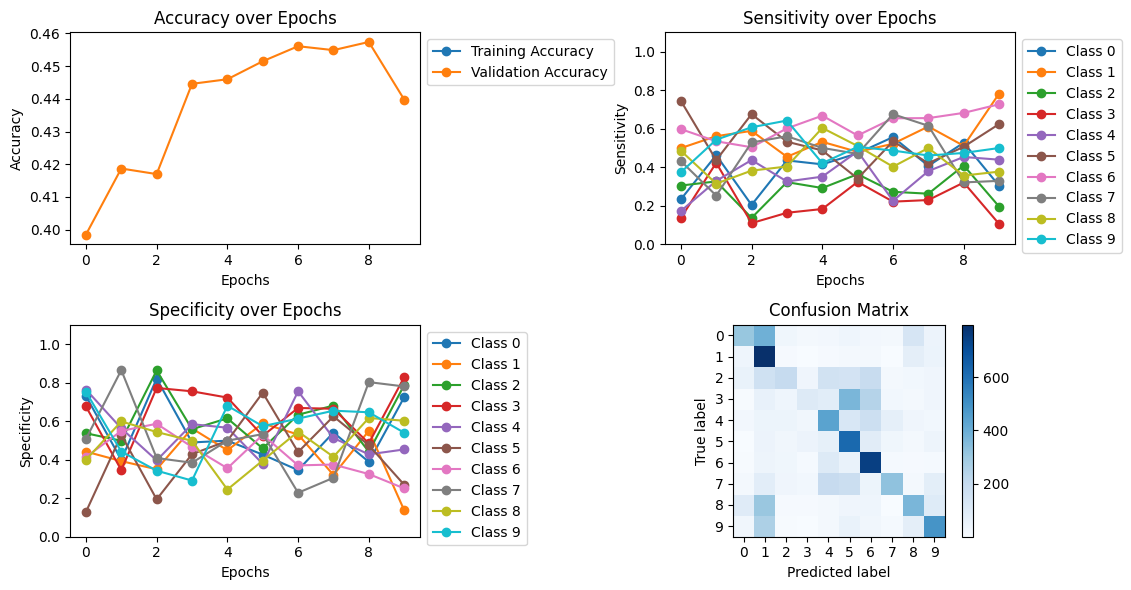

In [7]:
epochs = 10
results_mobilenet = train(
    device=device,
    model=model_mobilenet,
    train_dataloader=dataloaders["mobilenet_train"],
    epochs=epochs,
    val_dataloader=dataloaders["mobilenet_val"],
    run_filepath="models/mobilenet",
    plot=True,
    overwrite=False
)

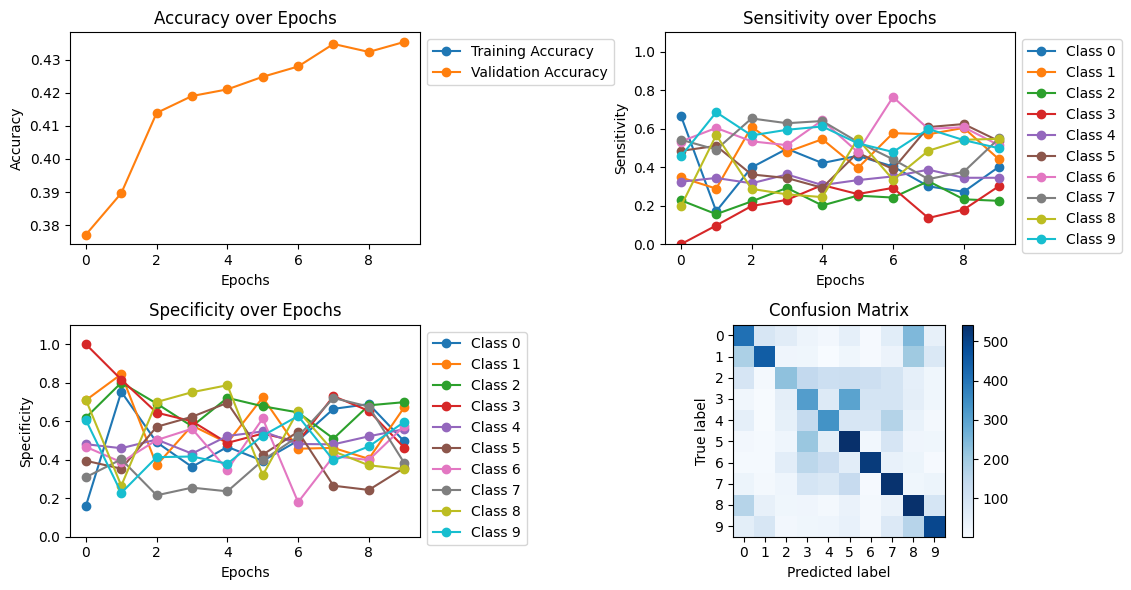

In [8]:
results_squeezenet = train(
    device=device,
    model=model_squeezenet,
    train_dataloader=dataloaders["squeezenet_train"],
    epochs=epochs,
    val_dataloader=dataloaders["squeezenet_val"],
    run_filepath="models/squeezenet",
    plot=True,
    overwrite=False,
    in_notebook=True
)

Model loaded from models/mobilenet/9.pth


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.4515
Test Sensitivity: [0.307 0.772 0.198 0.107 0.427 0.64  0.747 0.397 0.38  0.54 ]
Test Specificity: [0.7035533  0.14522293 0.77487923 0.81181818 0.48191758 0.27169811
 0.23041894 0.75       0.63329928 0.51977401]


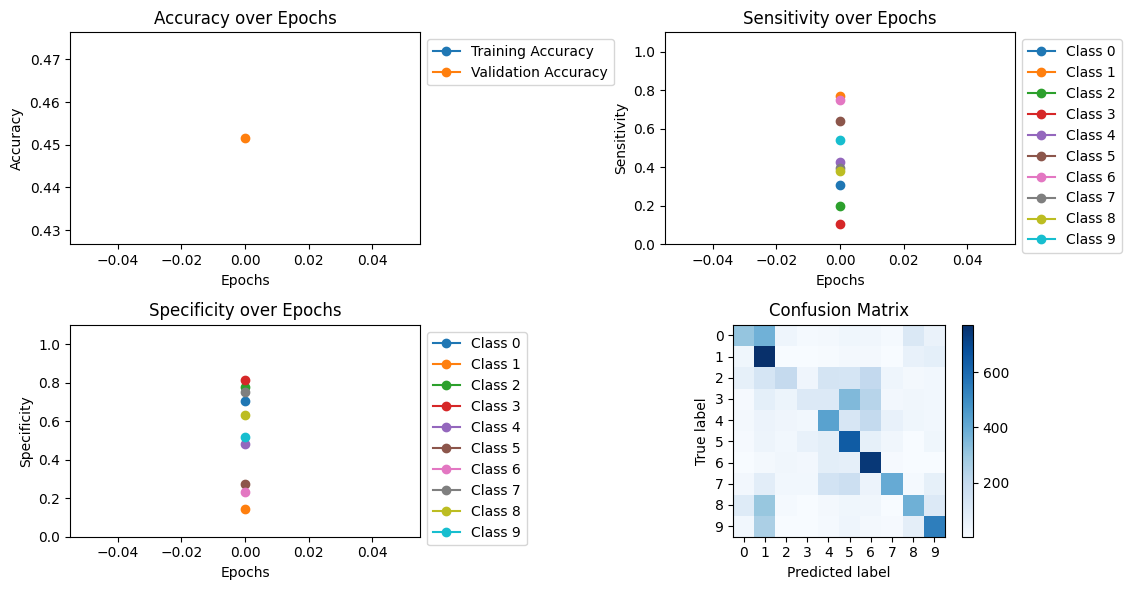

([0.4515],
 [array([[307, 376,  38,  14,  20,  34,  29,  14, 115,  53],
         [ 34, 772,   7,   6,   9,  16,  17,   6,  59,  74],
         [ 68, 135, 198,  36, 139, 134, 204,  38,  20,  28],
         [ 13,  74,  44, 107, 107, 347, 229,  22,  29,  28],
         [ 16,  49,  36,  27, 427, 125, 199,  62,  33,  26],
         [ 11,  42,  28,  61,  80, 640,  68,  31,   6,  33],
         [  4,  20,  31,  23,  81,  70, 747,  11,   6,   7],
         [ 22,  83,  28,  26, 146, 169,  48, 397,  14,  67],
         [ 98, 303,  14,   7,  19,  32,  31,   7, 380, 109],
         [ 26, 260,   7,   7,  15,  38,  20,  10,  77, 540]], dtype=int64)],
 [array([0.307, 0.772, 0.198, 0.107, 0.427, 0.64 , 0.747, 0.397, 0.38 ,
         0.54 ])],
 [array([0.7035533 , 0.14522293, 0.77487923, 0.81181818, 0.48191758,
         0.27169811, 0.23041894, 0.75      , 0.63329928, 0.51977401])])

In [9]:
model_mobilenet.load_model("models/mobilenet/9.pth")
test(model=model_mobilenet, test_dataloader=dataloaders["mobilenet_test"], device=device, plot=True, plotname="plots/mobilenet_mobilenet.png")

Model loaded from models/mobilenet/9.pth


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.2626
Test Sensitivity: [0.038 0.493 0.06  0.    0.403 0.645 0.307 0.052 0.323 0.305]
Test Specificity: [0.96007984 0.28355705 0.87198516 1.         0.26172731 0.12848353
 0.64345404 0.95180723 0.44104235 0.56596091]


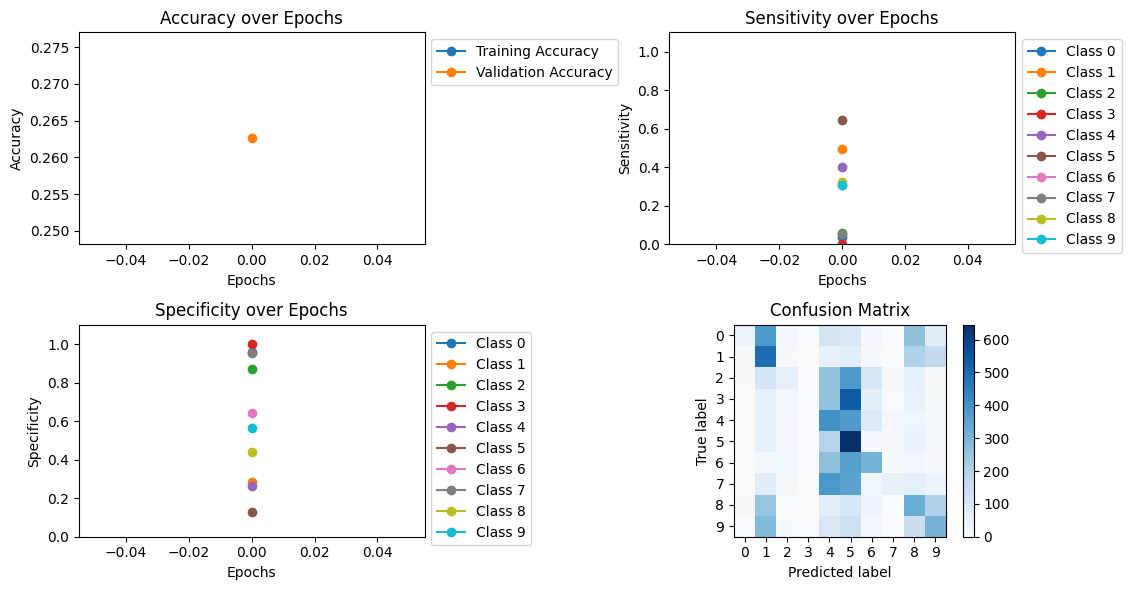

([0.2626],
 [array([[ 38, 380,  17,   0, 112,  96,  18,   0, 266,  73],
         [  8, 493,   7,   0,  50,  61,  10,   0, 206, 165],
         [ 10, 115,  60,   0, 257, 379, 104,  11,  54,  10],
         [  2,  54,  23,   0, 257, 538,  63,   3,  45,  15],
         [  4,  56,  20,   0, 403, 375,  88,  18,  26,  10],
         [  3,  54,  20,   0, 194, 645,  20,   8,  41,  15],
         [  1,  11,  23,   0, 265, 364, 307,   7,  16,   6],
         [  2,  72,  15,   0, 387, 351,  28,  52,  60,  33],
         [  9, 256,   4,   0,  66, 105,  31,   0, 323, 206],
         [  1, 283,   9,   0,  96, 139,  22,   1, 144, 305]], dtype=int64)],
 [array([0.038, 0.493, 0.06 , 0.   , 0.403, 0.645, 0.307, 0.052, 0.323,
         0.305])],
 [array([0.96007984, 0.28355705, 0.87198516, 1.        , 0.26172731,
         0.12848353, 0.64345404, 0.95180723, 0.44104235, 0.56596091])])

In [12]:
model_mobilenet.load_model("models/mobilenet/9.pth")
test(model=model_mobilenet, test_dataloader=dataloaders["squeezenet_test"], device=device, plot=True, plotname="plots/mobilenet_squeezenet.png")

Model loaded from models/squeezenet/9.pth


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.4448
Test Sensitivity: [0.425 0.437 0.224 0.35  0.334 0.535 0.536 0.555 0.558 0.494]
Test Specificity: [0.49654577 0.65694282 0.68672566 0.44097693 0.59570662 0.35307517
 0.54716981 0.40825688 0.35219124 0.59043174]


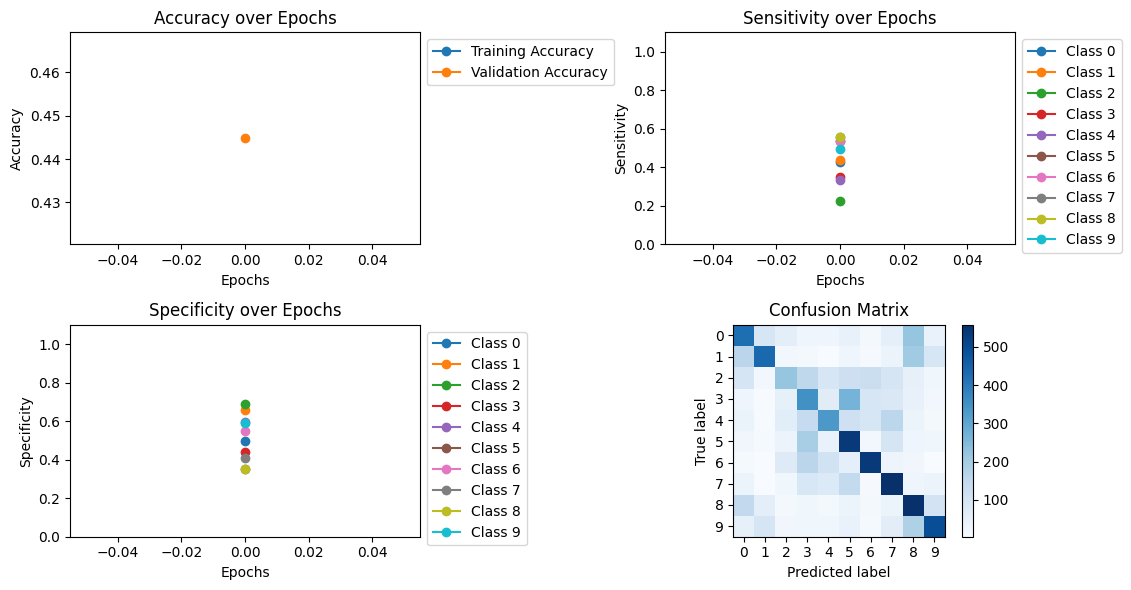

([0.4448],
 [array([[425,  92,  59,  27,  27,  43,  12,  51, 224,  40],
         [160, 437,  20,  14,   3,  26,   8,  36, 205,  91],
         [ 95,  19, 224, 153,  94, 121, 127,  96,  47,  24],
         [ 25,   6,  50, 350,  64, 267,  91,  82,  46,  19],
         [ 38,   6,  62, 140, 334, 120,  94, 158,  33,  15],
         [ 21,  11,  34, 194,  41, 535,  19,  95,  27,  23],
         [ 10,   3,  72, 161, 110,  53, 536,  30,  22,   3],
         [ 37,   5,  23,  88,  78, 145,   8, 555,  28,  33],
         [147,  57,  13,  24,  12,  36,  14,  36, 558, 103],
         [ 50,  95,  21,  23,  23,  41,  11,  61, 181, 494]], dtype=int64)],
 [array([0.425, 0.437, 0.224, 0.35 , 0.334, 0.535, 0.536, 0.555, 0.558,
         0.494])],
 [array([0.49654577, 0.65694282, 0.68672566, 0.44097693, 0.59570662,
         0.35307517, 0.54716981, 0.40825688, 0.35219124, 0.59043174])])

In [13]:
model_mobilenet.load_model("models/squeezenet/9.pth")
test(model=model_mobilenet, test_dataloader=dataloaders["squeezenet_test"], device=device, plot=True,
     plotname="plots/squeezenet_squeezenet.png")

Model loaded from models/squeezenet/9.pth


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.3835
Test Sensitivity: [0.249 0.386 0.171 0.365 0.241 0.397 0.724 0.245 0.619 0.438]
Test Specificity: [0.60418343 0.58034026 0.75432211 0.34454693 0.62623762 0.51937984
 0.23115578 0.85600907 0.22678571 0.58663883]


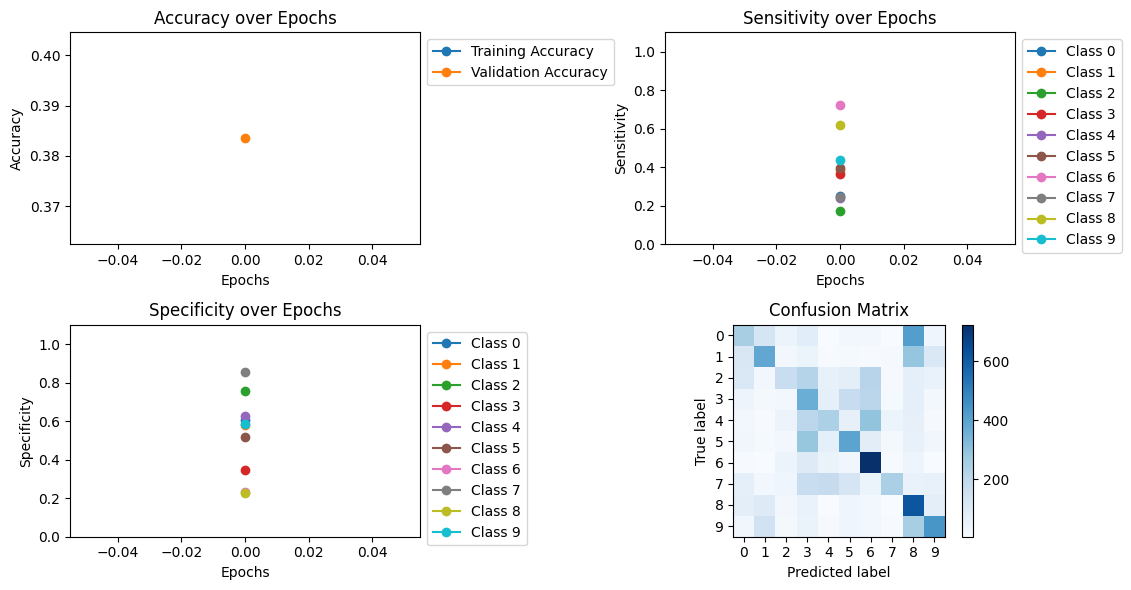

([0.3835],
 [array([[249, 123,  41,  82,   6,  21,  25,   4, 413,  36],
         [113, 386,  21,  43,   8,  13,   8,  10, 289, 109],
         [106,  22, 171, 222,  58,  72, 215,  11,  70,  53],
         [ 40,  17,  26, 365,  66, 173, 208,  15,  67,  23],
         [ 26,   9,  44, 206, 241,  61, 293,  47,  61,  12],
         [ 29,  15,  24, 286,  69, 397,  78,  19,  55,  28],
         [  7,   4,  43,  92,  51,  27, 724,   7,  40,   5],
         [ 70,  21,  33, 172, 179, 124,  47, 245,  53,  56],
         [ 73,  92,  22,  54,   5,  33,  22,   6, 619,  74],
         [ 28, 141,  16,  51,  11,  34,  22,   8, 251, 438]], dtype=int64)],
 [array([0.249, 0.386, 0.171, 0.365, 0.241, 0.397, 0.724, 0.245, 0.619,
         0.438])],
 [array([0.60418343, 0.58034026, 0.75432211, 0.34454693, 0.62623762,
         0.51937984, 0.23115578, 0.85600907, 0.22678571, 0.58663883])])

In [14]:
model_mobilenet.load_model("models/squeezenet/9.pth")
test(model=model_mobilenet, test_dataloader=dataloaders["mobilenet_test"], device=device, plot=True,
     plotname="plots/squeezenet_mobilenet.png")